Use GPyTorch
Use Spectral Mixture kernel

- all the components of the signal
- sub sampled

In [4]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read the first time series

In [5]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [6]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [7]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [8]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

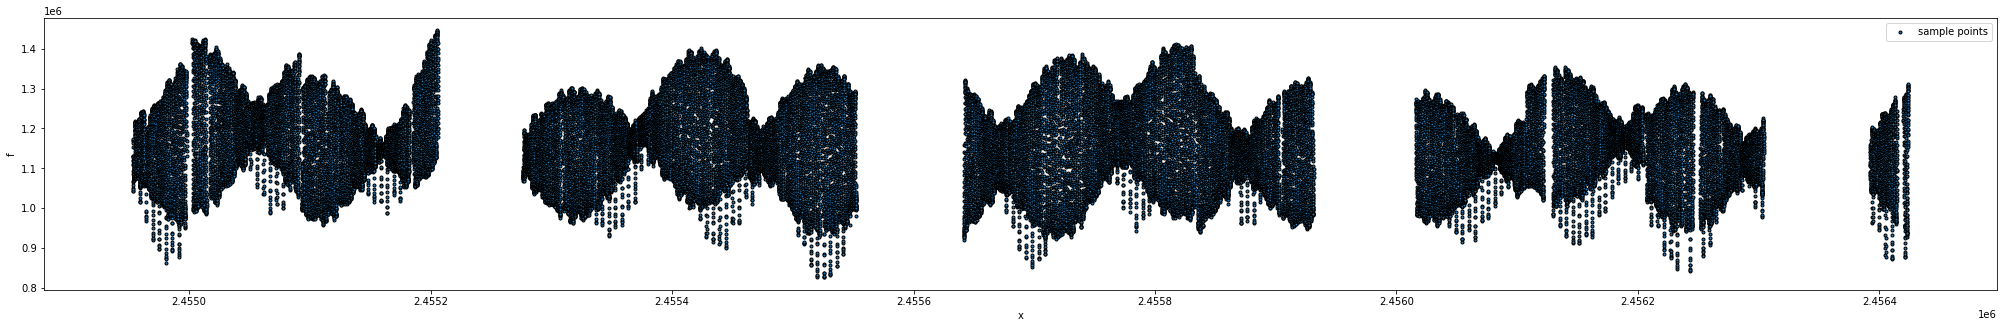

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [10]:
frequency, power = LombScargle(X, Y).autopower(minimum_frequency=-0, maximum_frequency=5)
frequency, power

(array([0.00000000e+00, 1.36011628e-04, 2.72023257e-04, ...,
        4.99978746e+00, 4.99992347e+00, 5.00005948e+00]),
 array([           inf, 1.58059443e-02, 1.55820745e-02, ...,
        3.85902562e-08, 5.24320651e-08, 1.11287175e-07]))

In [11]:
plt.figure(figsize=(35, 20))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

In [12]:
N_part=5000

In [13]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N_part], Y[:N_part], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [14]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [15]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [16]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [17]:
# normalize labels
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

In [18]:
X_part,Y_part

(tensor([2454953.5392, 2454953.5597, 2454953.5801,  ..., 2455066.3955,
         2455066.4159, 2455066.4363], dtype=torch.float64),
 tensor([-0.0927, -0.0703, -0.0492,  ...,  0.7456,  0.7237,  0.6506],
        dtype=torch.float64))

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

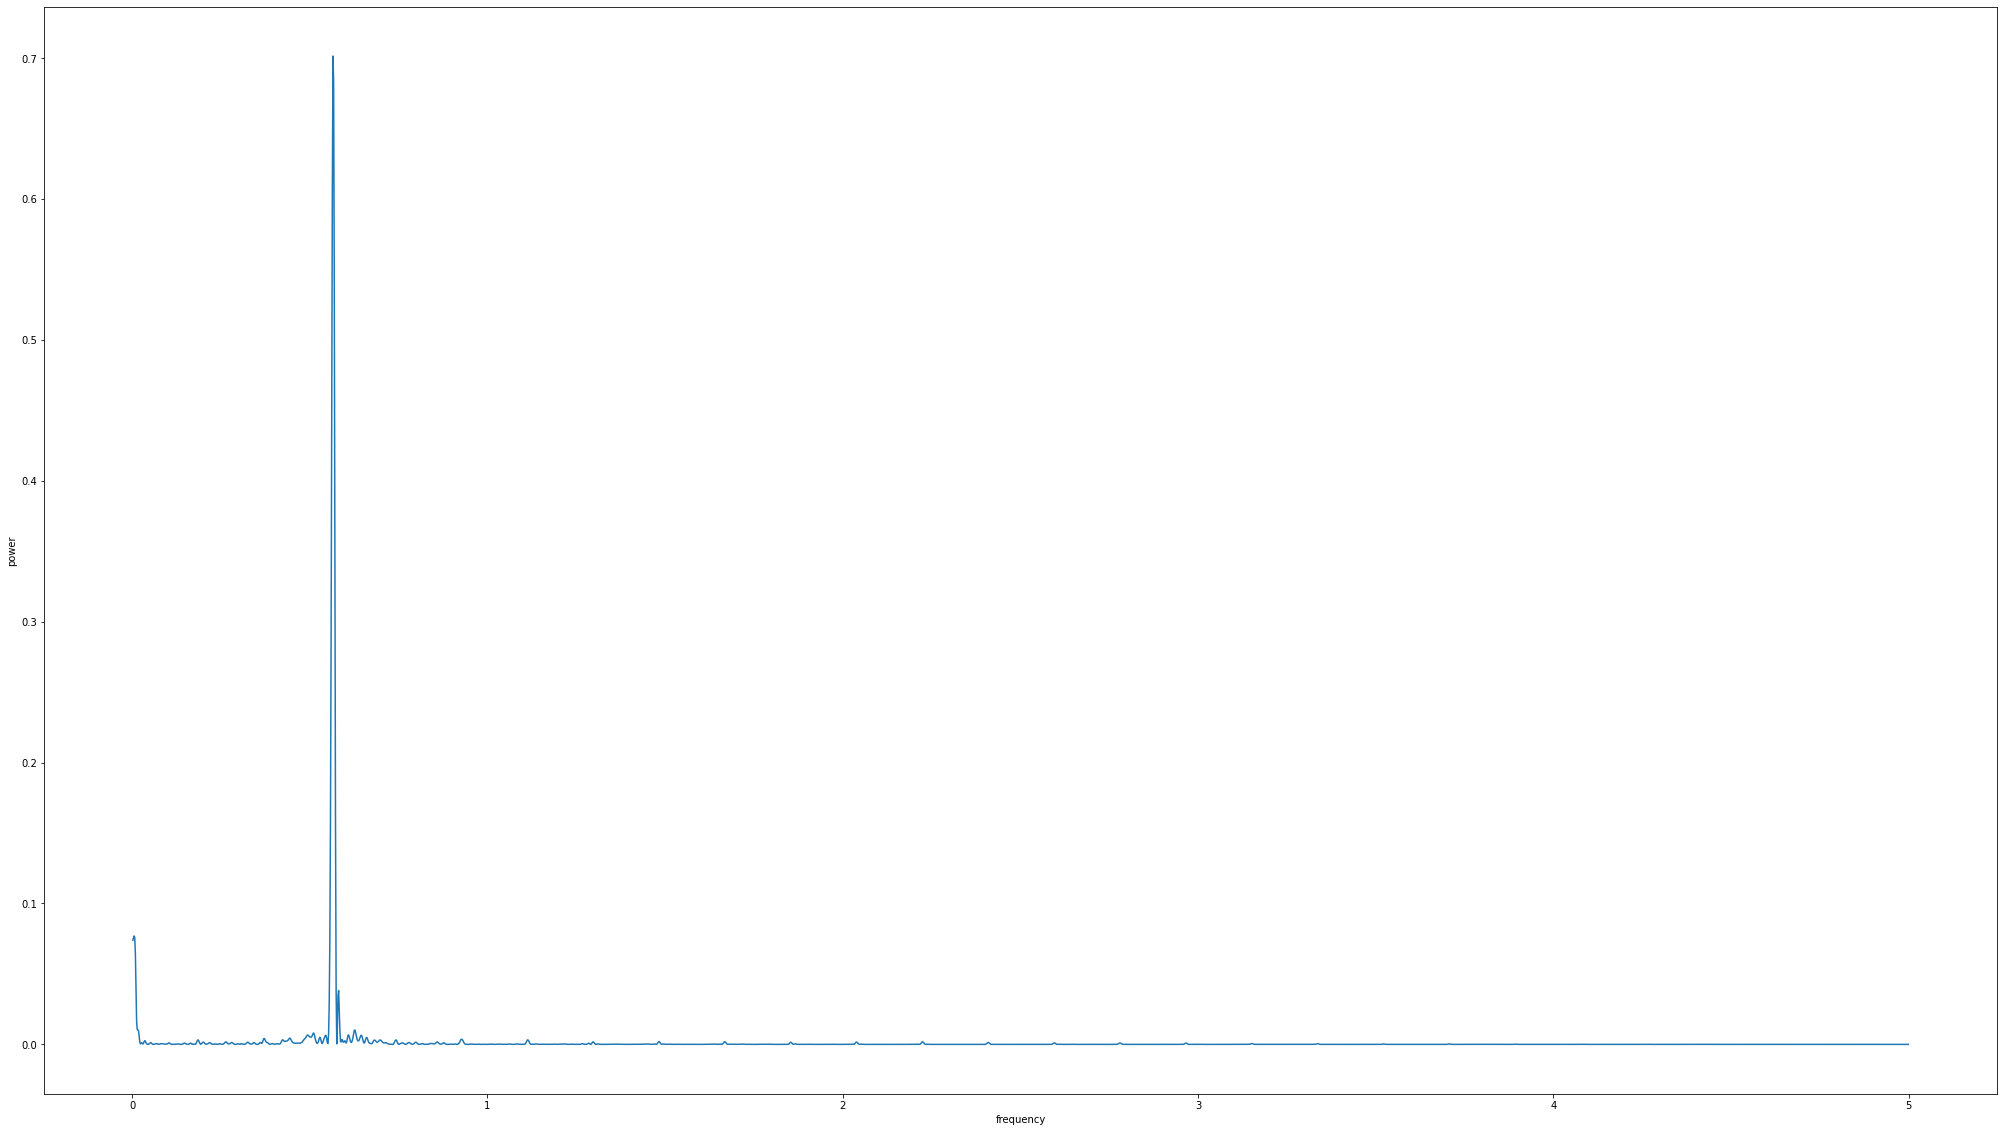

In [19]:
frequency, power = LombScargle(X_part, Y_part).autopower(minimum_frequency=0.0, maximum_frequency=5)
frequency, power
plt.figure(figsize=(35, 20))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

In [20]:
Y_part.cpu().numpy().mean()

3.637978807091713e-16

In [21]:
NUM_MIXTURES=25

In [22]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
#        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
#        self.covar_module = gpytorch.kernels.RBFKernel()
#        self.covar_module.lengthscale = 0.1
#        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
        self.covar_module = gpytorch.kernels.PeriodicKernel()
        self.covar_module.period_length = 1.7
        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(X_part, Y_part, likelihood)
model = SpectralMixtureGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [23]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [24]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.15)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.582   period: 0.000   noise: 0.693
Iter 2/50 - Loss: 1.560   period: 0.000   noise: 0.771
Iter 3/50 - Loss: 1.517   period: 0.000   noise: 0.853
Iter 4/50 - Loss: 1.496   period: 0.000   noise: 0.935
Iter 5/50 - Loss: 1.491   period: 0.000   noise: 1.014
Iter 6/50 - Loss: 1.481   period: 0.000   noise: 1.086
Iter 7/50 - Loss: 1.473   period: 0.000   noise: 1.150
Iter 8/50 - Loss: 1.467   period: 0.000   noise: 1.203
Iter 9/50 - Loss: 1.466   period: 0.000   noise: 1.242
Iter 10/50 - Loss: 1.465   period: 0.000   noise: 1.268
Iter 11/50 - Loss: 1.465   period: 0.000   noise: 1.282
Iter 12/50 - Loss: 1.462   period: 0.000   noise: 1.284
Iter 13/50 - Loss: 1.458   period: 0.000   noise: 1.276
Iter 14/50 - Loss: 1.453   period: 0.000   noise: 1.260
Iter 15/50 - Loss: 1.450   period: 0.000   noise: 1.237
Iter 16/50 - Loss: 1.446   period: 0.000   noise: 1.208
Iter 17/50 - Loss: 1.443   period: 0.000   noise: 1.175
Iter 18/50 - Loss: 1.440   period: 0.000   noise: 1.139
I

In [25]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

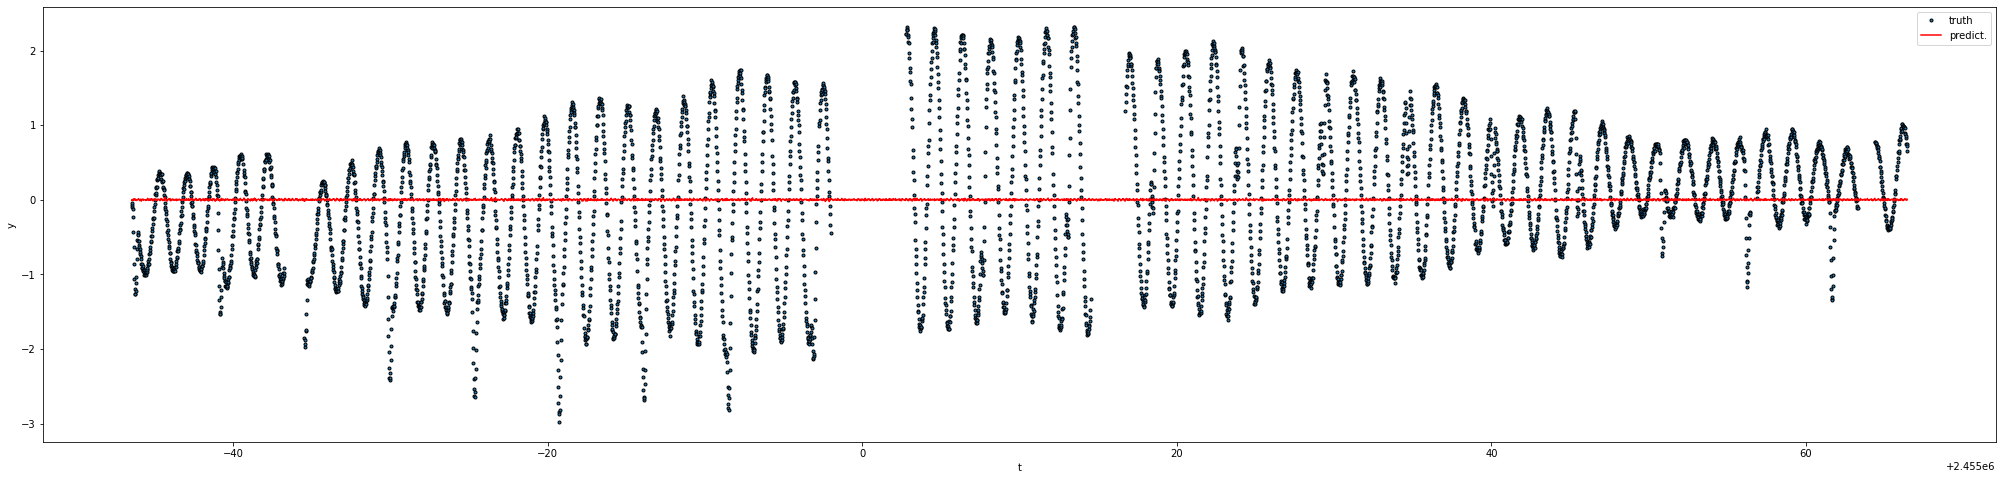

In [26]:
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

In [27]:
# Save the model if it's better than previous model
torch.save(model.state_dict(), '../models/time_series_gpytorch_eb_sm1.pth')

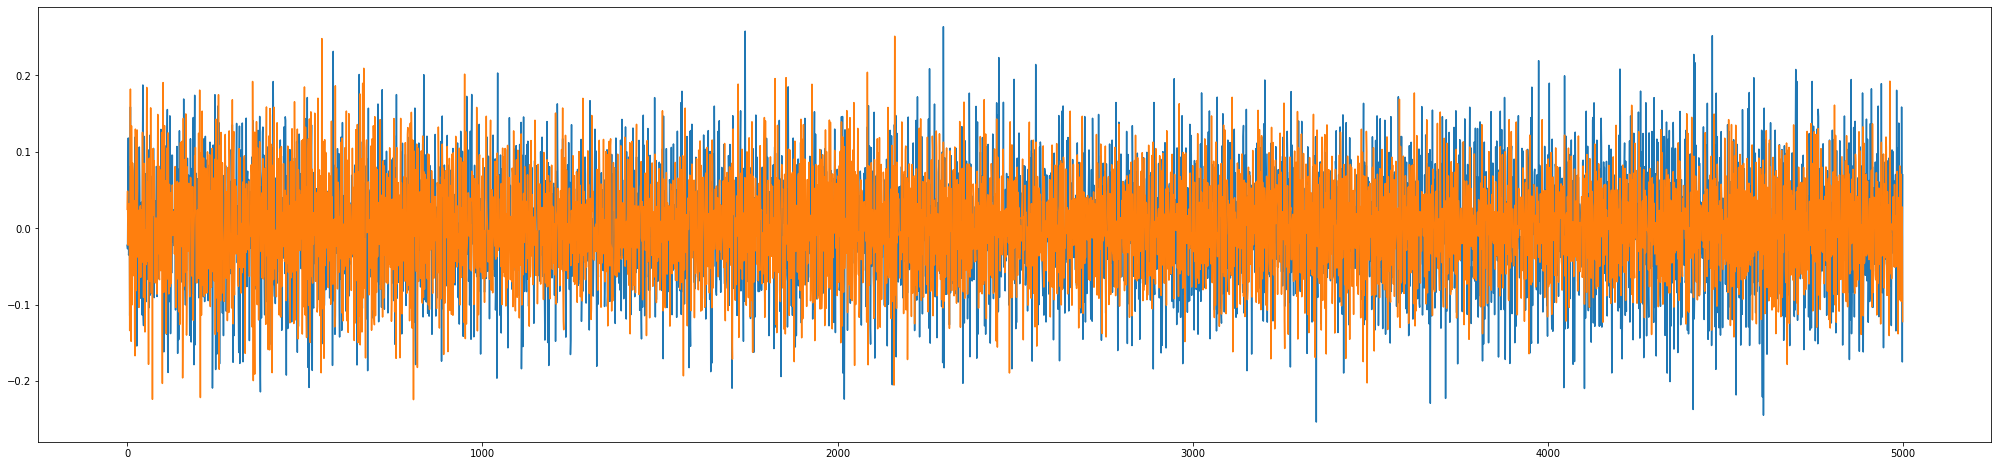

In [28]:
# Plot some samples of the kernel
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_kernel_samples(model, X_part_smooth, nr_of_samples=2)

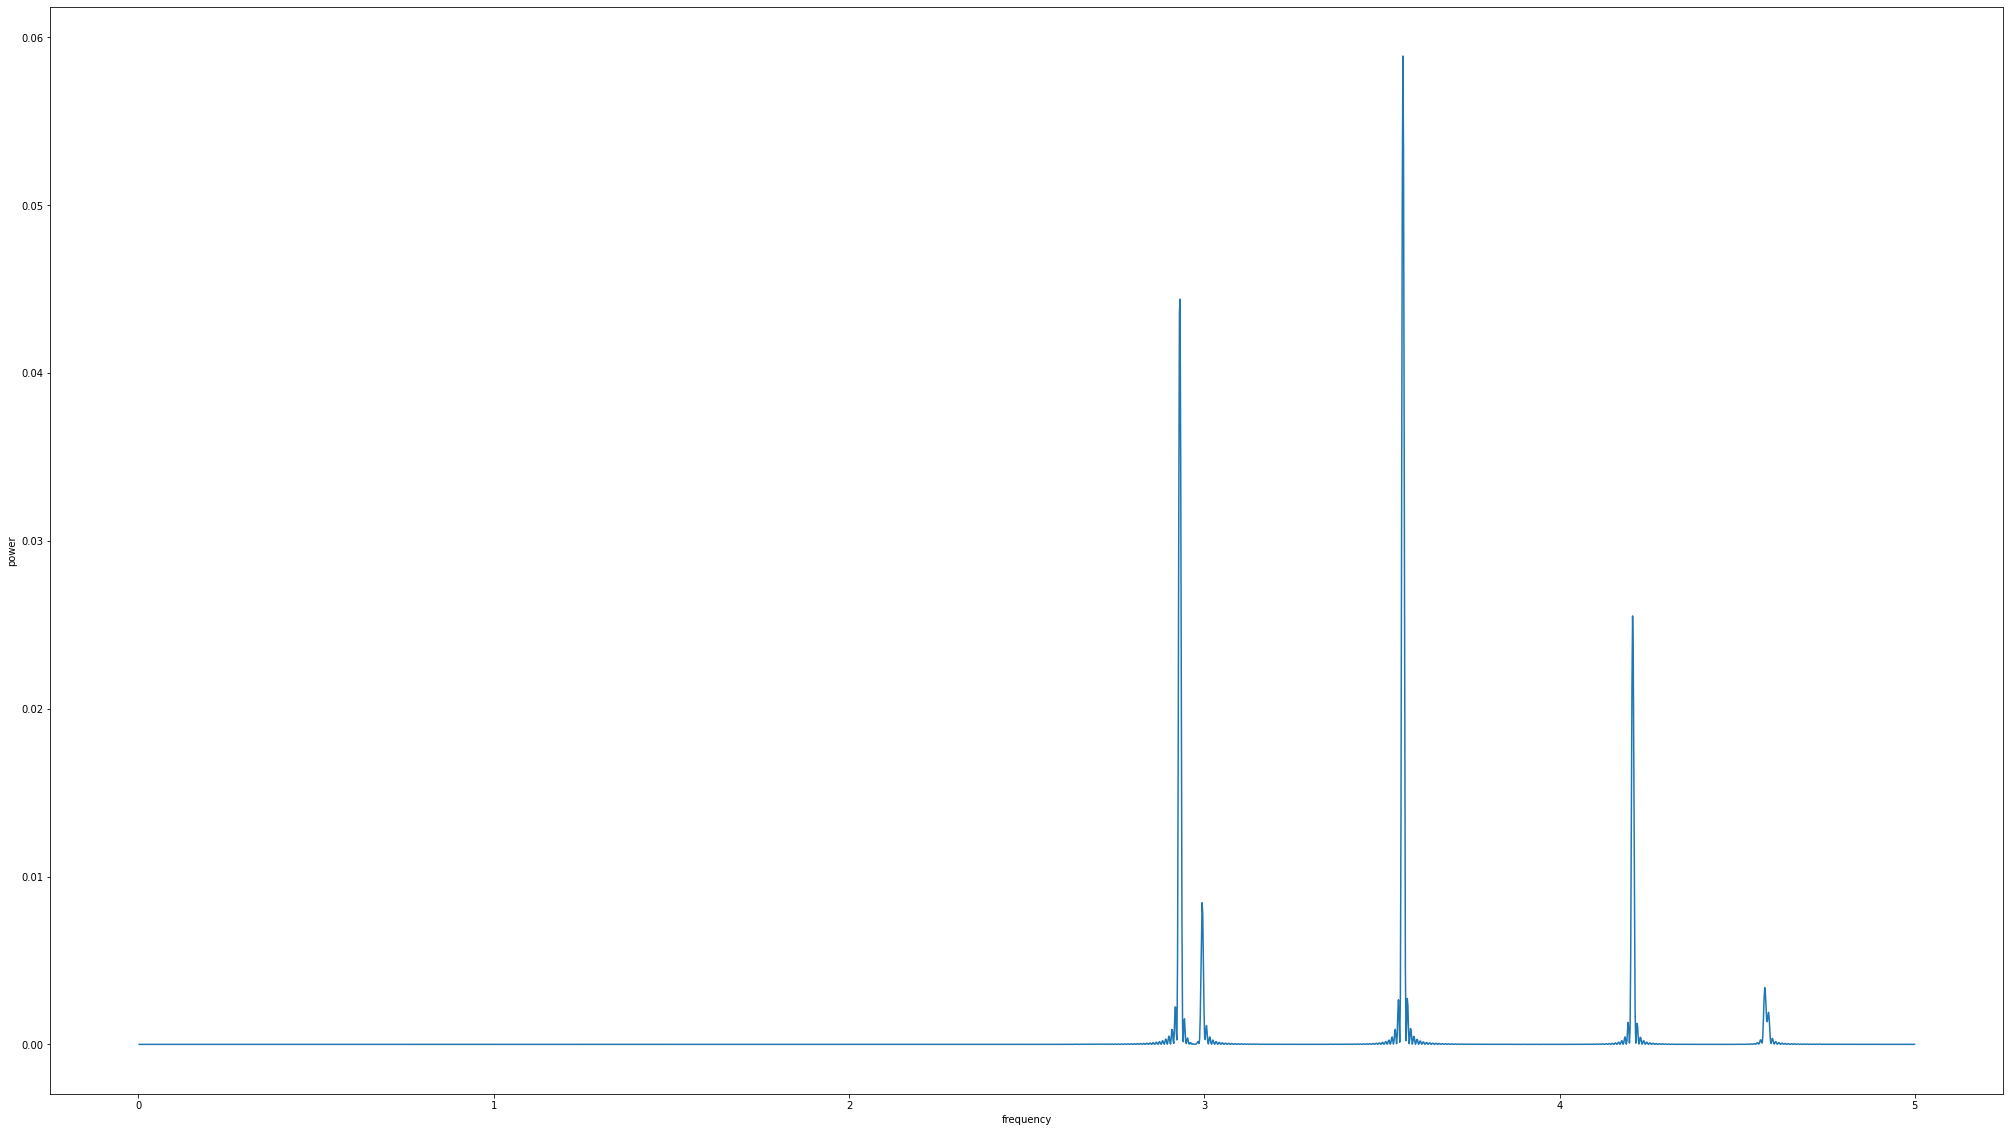

In [29]:
# Plot the periodogram of one sample
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_sample = model(X_part_smooth).sample()
    frequency, power = LombScargle(X_part_smooth, Y_sample).autopower(minimum_frequency=0.0, maximum_frequency=5)
    plt.figure(figsize=(35, 20))
    plt.plot(frequency, power)
    plt.xlabel("frequency"), plt.ylabel("power")

In [30]:
with torch.no_grad():
    scales = model.covar_module.mixture_scales.cpu().numpy().tolist()
    print("Mixture scales: ", scales.sort())
    print("Micture means:", model.covar_module.mixture_means.cpu().numpy())

Mixture scales:  None
Micture means: [[[16.13262236]]

 [[12.13285368]]

 [[ 7.23519313]]

 [[10.89972132]]

 [[14.48813148]]

 [[ 2.99620021]]

 [[21.0314484 ]]

 [[ 4.58188246]]

 [[10.22876597]]

 [[13.39577116]]

 [[ 6.8097748 ]]

 [[ 9.13492733]]

 [[13.89295119]]

 [[ 3.55990141]]

 [[12.76663558]]

 [[12.46582691]]

 [[19.99094541]]

 [[11.57006208]]

 [[ 4.20522549]]

 [[ 2.93189296]]

 [[12.79891054]]

 [[16.19716848]]

 [[ 8.50557127]]

 [[23.45089469]]

 [[15.42983885]]]


In [31]:
scales

[[[0.00026820832949374086]],
 [[0.0003385326709355927]],
 [[0.00033991091253711685]],
 [[0.0003784967187401933]],
 [[0.0004697831769598184]],
 [[0.0004722175267170919]],
 [[0.0004968448762957095]],
 [[0.000523270066497412]],
 [[0.0005539375821838765]],
 [[0.0005665444354763205]],
 [[0.0005878561831653793]],
 [[0.0006901865079326894]],
 [[0.0007206176243216559]],
 [[0.0007711168096068372]],
 [[0.0007780707575869672]],
 [[0.0008323435930224851]],
 [[0.0008725100809289869]],
 [[0.0009276245450020257]],
 [[0.0009455219972513636]],
 [[0.0009551154832574773]],
 [[0.0010355737963794235]],
 [[0.001040869724149938]],
 [[0.0011868190684577382]],
 [[0.004367378871629791]],
 [[0.012381465659936369]]]

In [32]:
with torch.no_grad():
    residuals = Y_part.cpu()-observed_pred.mean.cpu().numpy()

In [33]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [34]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part))
    
np.sqrt(np.nanmean((observed_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.9998175441465756